In [1]:
# If gspx is not installed, we add it to the path
import os, sys
gdir = os.path.dirname(os.getcwd())  # parent folder
sys.path.insert(0, gdir)

In [2]:
import numpy as np
rnd = np.random.RandomState(42)
N = 10
moduli = rnd.uniform(size=N)
component = rnd.randint(4, size=10)

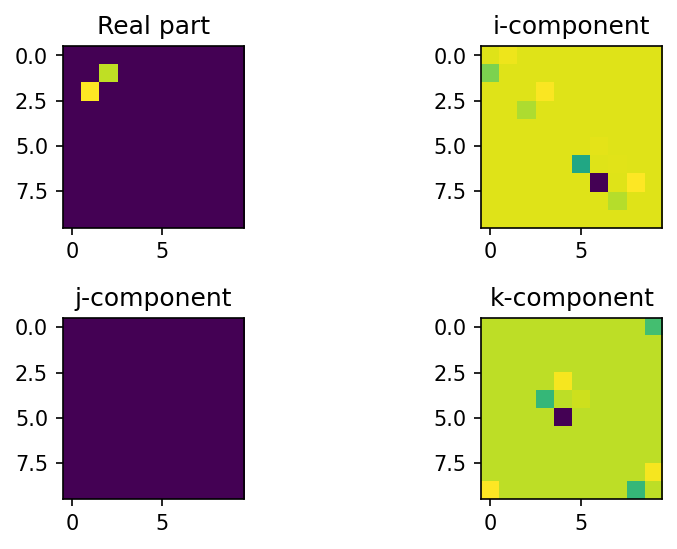

In [3]:
import networkx as nx
from gspx.utils.graph import adj_matrix_ring
from gspx.signals import QuaternionSignal
from pyquaternion import Quaternion
from gspx.utils.display import visualize_quat_mtx


s = QuaternionSignal([
    dict(array=np.eye(4)[c] * moduli[i]) for i, c in enumerate(component)
])
s_inv = QuaternionSignal()
s_inv.samples = np.array([q.inverse for q in s.samples])

# Weight matrix for the quaternion unit graph
W = (
    adj_matrix_ring(weights=s.samples) +
    adj_matrix_ring(weights=s_inv.samples).transpose()
)

visualize_quat_mtx(W, dpi=150)

In [4]:
np.abs(W * W.transpose())

array([[0, 0.9999999999999999, 0, 0, 0, 0, 0, 0, 0, 1.0],
       [0.9999999999999999, 0, 1.0000000000000002, 0, 0, 0, 0, 0, 0, 0],
       [0, 1.0000000000000002, 0, 1.0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1.0, 0, 1.0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1.0, 0, 1.0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1.0, 0, 1.0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1.0, 0, 0.9999999999999999, 0, 0],
       [0, 0, 0, 0, 0, 0, 0.9999999999999999, 0, 1.0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1.0, 0, 1.0],
       [1.0, 0, 0, 0, 0, 0, 0, 0, 1.0, 0]], dtype=object)

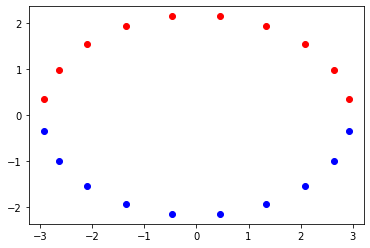

In [6]:
from gspx.utils.quaternion_matrix import complex_adjoint
import matplotlib.pyplot as plt

W_adj = complex_adjoint(W)
eig, V = np.linalg.eig(W_adj)

mask = np.imag(eig) < 0

plt.plot(np.real(eig[np.where(mask)]), np.imag(eig)[np.where(mask)], 'bo')
plt.plot(np.real(eig[np.where(~mask)]), np.imag(eig)[np.where(~mask)], 'ro')
plt.show()

In [93]:
from gspx.utils.graph import coords_ring_graph

coords = coords_ring_graph(N)
A = (W != 0).astype(int)

s = 0.5 + 0.1 * np.cos(coords[:, 0]) + 0.1 * np.sin(coords[:, 1])
rnd = np.random.default_rng(seed=2)
sn = s + rnd.random(size=len(s))

g = nx.from_numpy_matrix(A)

print("MSE:", np.linalg.norm(s - sn)**2)

MSE: 2.2660453372541656


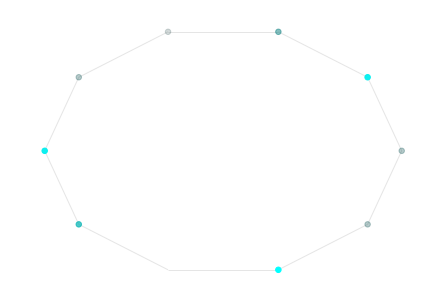

In [94]:
import matplotlib.pyplot as plt

# plt.figure(figsize=(5, 10))
# node_color = [tuple(rgba) for rgba in s.to_rgba()]
color_signal = (sn - np.min(sn)) / (np.max(sn) - np.min(sn))
node_color = [tuple([0, rgba, rgba, rgba]) for rgba in color_signal]
nx.draw(
    g, pos=coords, node_size=30,
    edge_color=(0.8, 0.8, 0.8, 0.5),
    with_labels=False, node_color=node_color)

# q-QLMS

In [110]:
class qQLMS:
    def __init__(
            self, q=1.0, mu=2, niter=100, rtol=0.05, seed=42,
            verbose=True):
        self.q = q
        self.rnd = np.random.default_rng(seed=seed)
        self.verbose = verbose
        self.niter = niter
        self.rtol = rtol
        self.mu = mu

    def run(self, X, d):
        """Fit the algorithm"""
        n_feat, n_obs = X.shape
        assert len(d) == n_obs

        w_previous = self.initiate(n_feat)

        r_err = 2 * self.rtol
        niter = 0
        err_previous = 0
        # while r_err > self.rtol and niter < self.niter:
        for i in range(n_obs):
            x = X[:, i].copy()
            y = np.sum(w_previous.conjugate() * x)
            err = d[i] - y

            r_err = np.abs((err - err_previous) / (err + 1e-7))

            w_previous = self.update(w_previous, x, err)
            print("MSE:", np.mean(np.abs(err * err.conjugate())))
            print("r_err:", np.mean(r_err**2))

    def initiate(self, n_feat):
        return self.rnd.normal(loc=0.0, scale=1.0, size=n_feat)

    def update(self, w_previous, x, err):
        w_next = w_previous + self.mu * (
            0.5 * x * err.conjugate()
        )
        return w_next


In [111]:
eigq = eig[np.where(np.imag(eig) < 0)]

In [114]:
X = np.vander(eigq, increasing=True).T  # each observation is the power series of one eigenvalue
d = np.zeros(N)
d[:int(N/4)] = 1.0

In [115]:
opt = qQLMS(mu=0.5)
opt.run(X, d)

MSE: 220711590.67980385
r_err: 0.9999999999929945
MSE: 1.31102386139661e+23
r_err: 1.0
MSE: 4.278869530796871e+35
r_err: 1.0
MSE: 2.463468406907007e+47
r_err: 1.0
MSE: 1.1995859762048197e+61
r_err: 1.0
MSE: 8.99789431635799e+75
r_err: 1.0
MSE: 4.3815299423551673e+89
r_err: 1.0
MSE: 2.5225805950619244e+101
r_err: 1.0
MSE: 8.233068804758847e+113
r_err: 1.0
MSE: 4.8904307273270655e+128
r_err: 1.0


In [1]:
import numpy as np
import math

def hypothesis(x, theta):
    """
    x is training set
    theta is weight parameter
    """
    return np.transpose(np.array(theta)).dot(np.array(x))

def costFunction(theta, x, y):
    """
        x is training set => (j, 2)
        y is a vector of
        theta is weight parameter
        """
    factor = 1 / 2
    sum = 0
    for i in range(0, len(x)):
        sum += math.pow((hypothesis(x[i], theta) - y[i]), 2)
    return factor * sum

def learnThetaSingle(theta, x, y, alpha):
    return theta + alpha * (y - hypothesis(x, theta)) * x

def learnTheta(theta, x, y, alpha):
    f = theta
    for i in range(0, len(x)):
        f = learnThetaSingle(f, x[i], y[i], alpha)
    return f

testX = np.array([[1, 2],
                   [4, 6],
                   [5, 123],
                   [41, -14],
                   [-413, 0],
                   [0, 0],
                   [5, 12],
                   [-3, -14],
                   [1, 1004],
                   [51, 51]])

testY = np.array([3, 10, 128, 27, -413, 0, 17, -17, 1005, 102])
theta = [2, 3]
print(costFunction(theta, testX, testY)) 
# 2147656.0
theta = learnTheta(theta, testX, testY, 0.0001)
print(theta)
#[-29.59330648  68.71968433] , this is far from true

2147656.0
[-29.59330648  68.71968433]
